In [1]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob
from tabulate import tabulate

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Read all files

In [2]:
# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
input_size = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 2**28]
input_type = ["Sorted", "ReverseSorted", "Random", "1_perc_perturbed"]
measurement_regions = ['main', 'comp_large', 'comm']

In [3]:
bitonic_tk = {}
for in_type in input_type:
    bitonic_tk[in_type] = th.Thicket.from_caliperreader(glob("../bitonic_ipynb/Bitonic_Cali/*-{}.cali".format(in_type)))
sample_tk = {}
for in_type in input_type:
    sample_tk[in_type] = th.Thicket.from_caliperreader(glob("../sample_ipynb/cali/*-s{}*.cali".format(in_type)))
merge_tk = {}
for in_type in input_type:
    merge_tk[in_type] = th.Thicket.from_caliperreader(glob("../merge_ipynb/Merge_Cali/*-{}.cali".format(in_type)))
radix_tk = {}
for in_type in input_type:
    radix_tk[in_type] = th.Thicket.from_caliperreader(glob("../radix_ipynb/Radix_Cali/*-s{}.cali".format(in_type)))

(2/2) Creating Thicket: 100%|██████████████████| 69/69 [00:00<00:00, 178.45it/s]
/home/jeffrey/anaconda3/lib/python3.12/site-packages/thicket/ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)
(2/2) Creating Thicket: 100%|██████████████████| 69/69 [00:00<00:00, 193.03it/s]
/home/jeffrey/anaconda3/lib/python3.12/site-packages/thicket/ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment usi

View Calltree

In [4]:
# Not very useful if counting from multiple cali files:
#print(tk.tree(metric_column="Avg time/rank"))

In [5]:
#tk.metadata.columns

In [6]:
#tk.metadata.head(1)

In [7]:
#for node in tk['Random'].graph.traverse():
#    print(node)

In [8]:
#tk['Random'].dataframe

Group Performance data by `input_size` in the Thicket metadata table.

In [9]:
for tk in [bitonic_tk, sample_tk, merge_tk, radix_tk]:
    for in_type in tk:
        tk[in_type].metadata_column_to_perfdata("num_procs")
        tk[in_type].metadata_column_to_perfdata("input_size")
        #tk.metadata_column_to_perfdata("input_type")

        tk[in_type].dataframe = tk[in_type].dataframe.reset_index().set_index(["node", "num_procs", "input_size"]).sort_index()

        #tk.dataframe.head()

In [10]:
# Change font size for all plots
plt.rcParams.update({"font.size": 20})

In [11]:
#tk.dataframe.head(25)

In [12]:
#define function for graphing in matplotlib:
def show_mpl_plot(fig, ax, title, xlabel, ylabel, legend, ylim=None, ylog=False):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if (legend):
        ax.legend(legend)
    else:
        ax.legend()
    plt.xscale("log", base=2)
    plt.xticks(processes)
    ax.set_xticklabels(processes)

    if (ylog):
        plt.yscale("log", base=10)
    
    if (ylim):
        plt.ylim(ylim)
    else:
        plt.ylim(bottom=0)
    
    plt.savefig(f'plots/{title}')
    plt.show()
    return fig, ax


def plot_mpl(df, title, xlabel, ylabel, legend, ylim=None):
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(
        df,
        marker='o',
    )
    return show_mpl_plot(fig, ax, title, xlabel, ylabel, legend, ylim=ylim)
    

### For each implementation:
- For each of comp_large, comm, and main:
    - Strong scaling plots for each input_size with lines for input_type (7
    plots - 4 lines each)
    - Strong scaling speedup plot for each input_type (4 plots)
    - Weak scaling plots for each input_type (4 plots)

- in Radix Sort case, chose to forgo and only have the 6 plots as last problem size would exceed 6 hours (not ideal)


Merge sort will have $3 \cdot (7 + 4 + 4) = 45$ plots.
(However, at the time of writing, Grace has a network error that prevents `p=1024` jobs from running. Thus, 18 `p=1024` Caliper files are still missing.)

### Strong Scaling
- fixed problem size while increasing number of processors/nodes

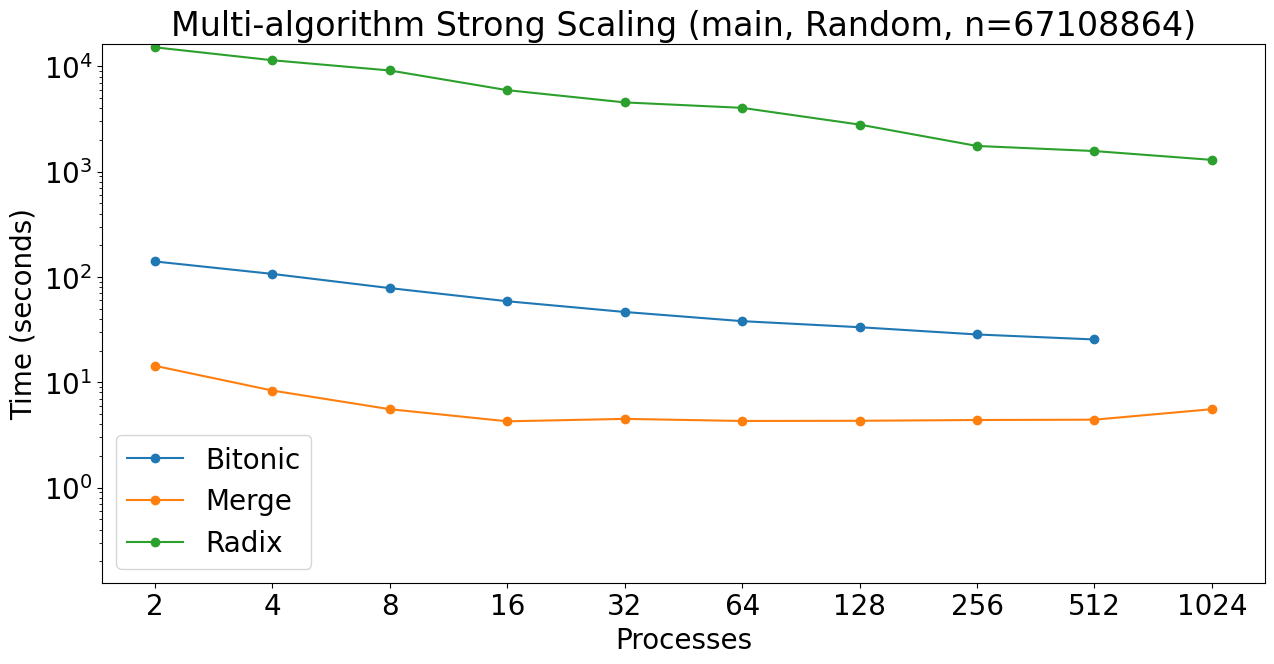

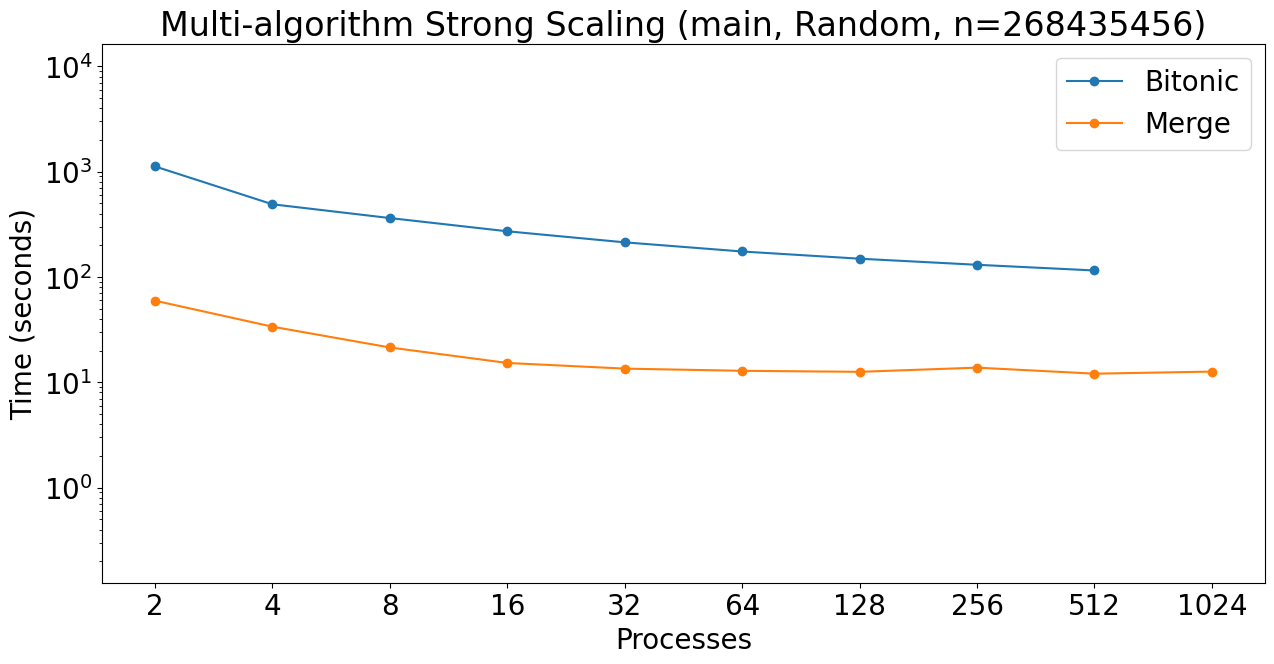

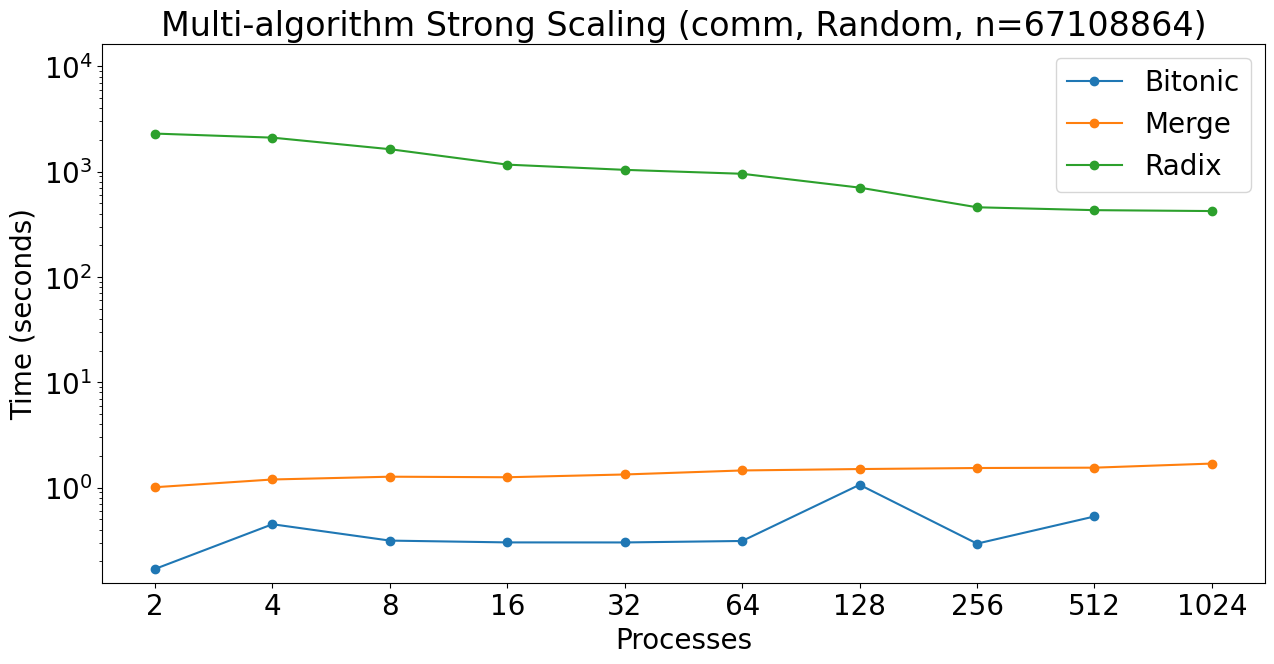

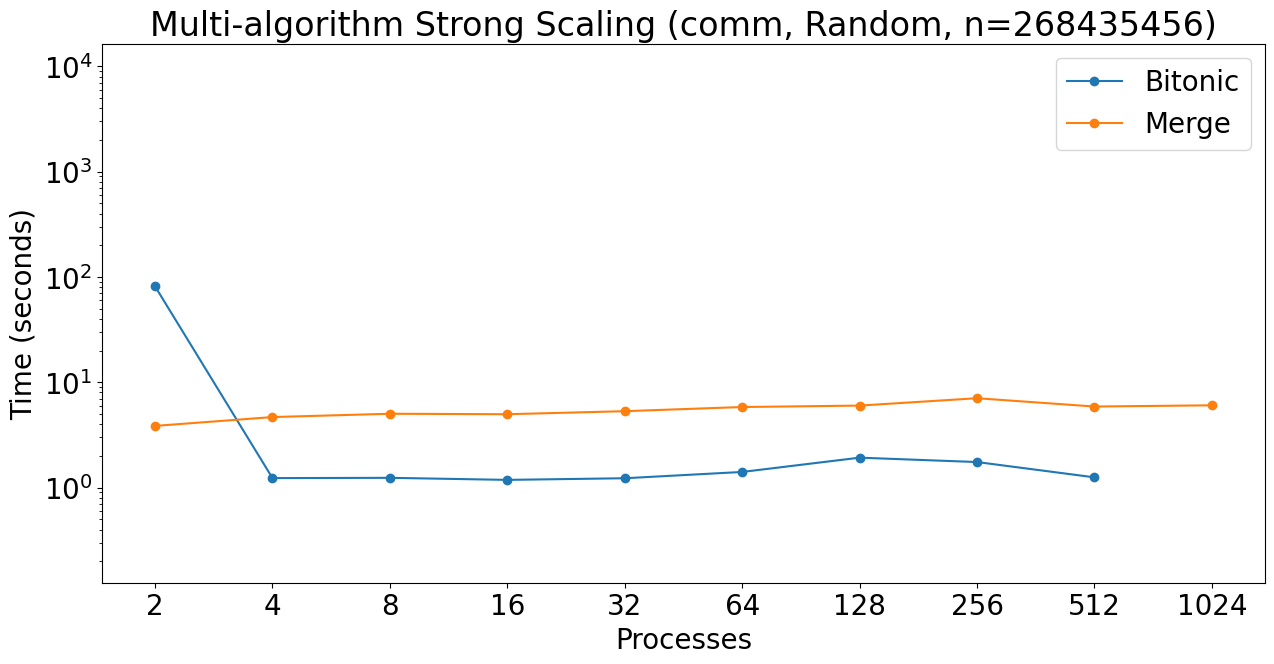

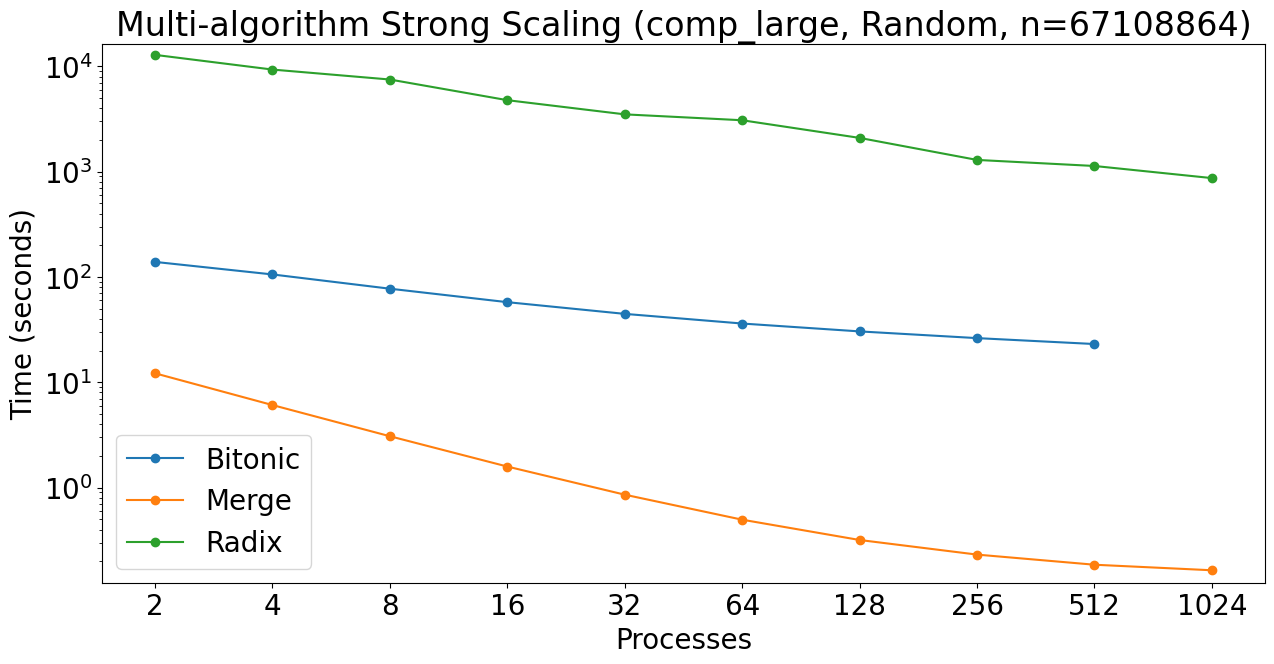

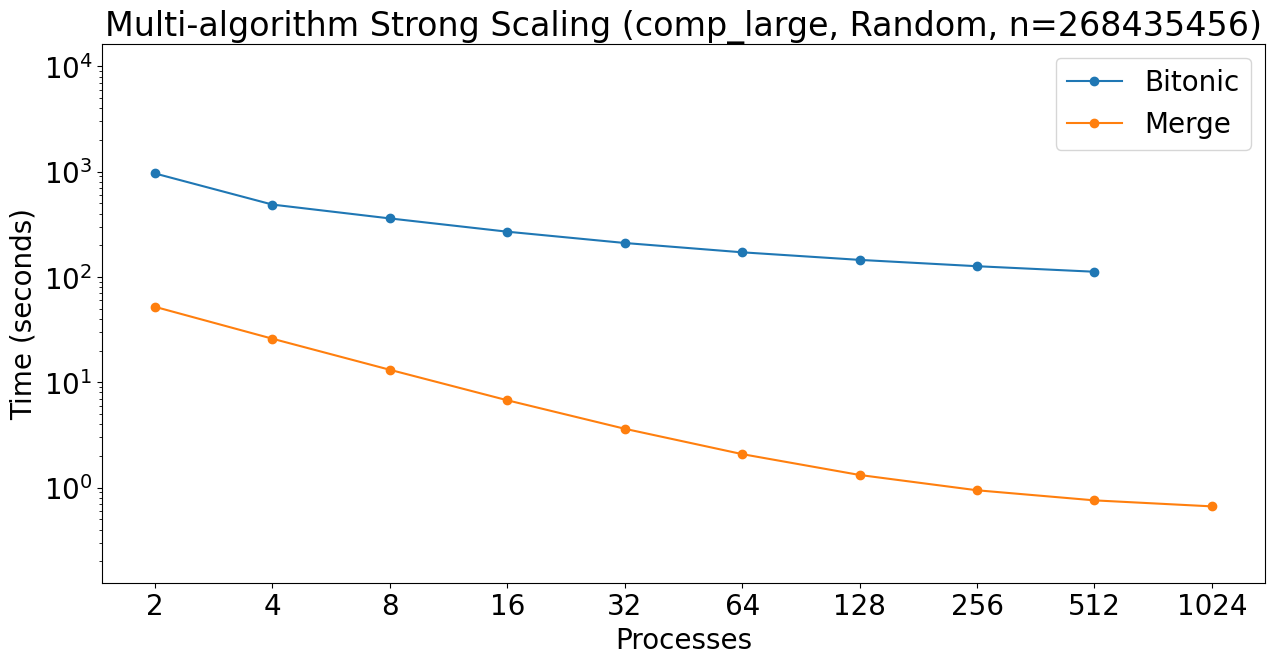

In [13]:
#iterate through nodes, and if comp_large, comm, or main, print the strong scaling
title_template = "Multi-algorithm Strong Scaling ({}, {}, n={})"#, scaled for synchronized y limits)"
for node in merge_tk['Random'].graph.traverse():

    if node.frame['name'] == 'main' or node.frame['name'] == 'comp_large' or node.frame['name'] == 'comm':
        # for input size n, plot 4 plots for each input_type
        for arySize in [2**26, 2**28]:

            in_type = 'Random'

            fig = plt.figure(figsize=(15,7))
            ax = fig.add_subplot(1, 1, 1)
            
            # title will be node.frame['name']_input_size
            title = title_template.format(node.frame['name'], in_type, arySize)

            #for in_type in input_type:
            for name, tk in [('Bitonic', bitonic_tk), ('Sample', sample_tk), ('Merge', merge_tk), ('Radix', radix_tk)]:
                df = tk[in_type].dataframe.loc[node, 'Avg time/rank'] # get average time
                df = (df.loc[df.index.get_level_values('input_size') == arySize])
                df = (df.loc[df.index.get_level_values('num_procs') != 1])
                #df = df.unstack(level="input_type")
                df = df.unstack(level="input_size")
                ax.plot(df, marker='o', label=name)
                
            show_mpl_plot(fig, ax, title, "Processes", "Time (seconds)", None,
                          #ylim=(0, 15200), # Synchronized with other groupmates
                          #ylim=(0, 112.5), # Synchronized only with merge sort strong scaling
                          ylim=(2**-3, 2**14),
                          ylog=True,
                         )
    

### Strong Scaling Speedup for each input type
- For this, we will do fixed size speedup for the $S_p =\frac{T_2}{T_p}$ for each input_type given problem size $2^{26}$. 

main


/tmp/ipykernel_11219/319951227.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ylim)


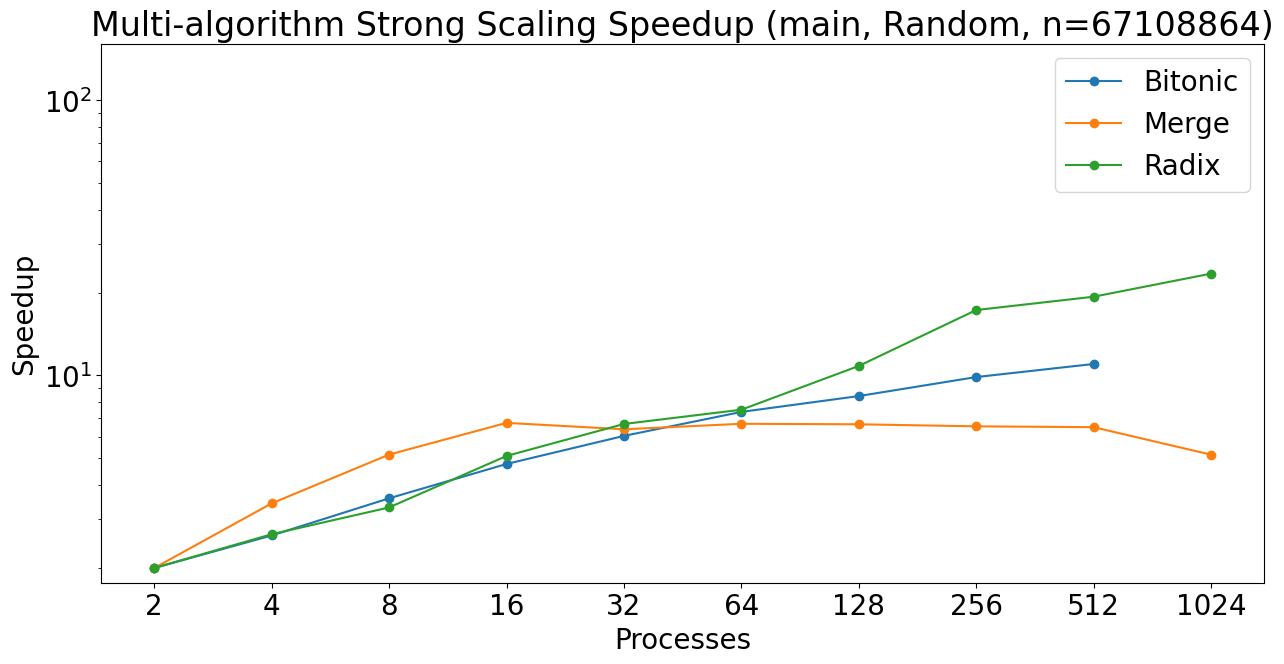

/tmp/ipykernel_11219/319951227.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ylim)


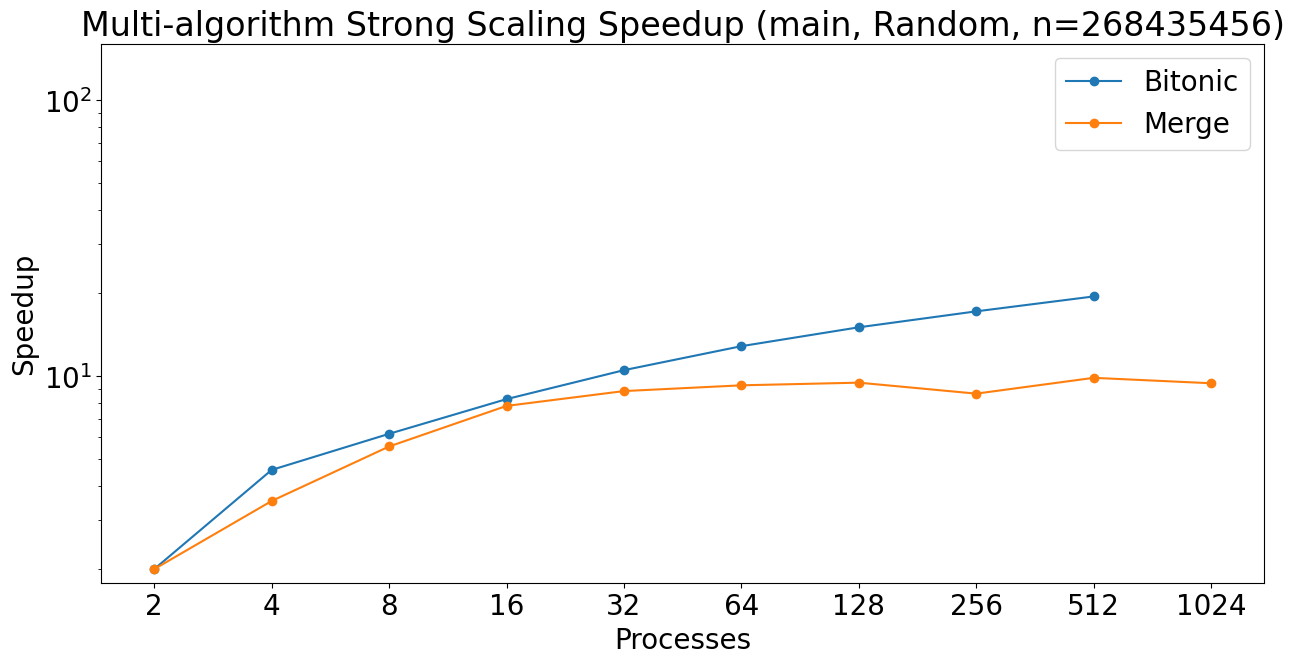

comm


/tmp/ipykernel_11219/319951227.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ylim)


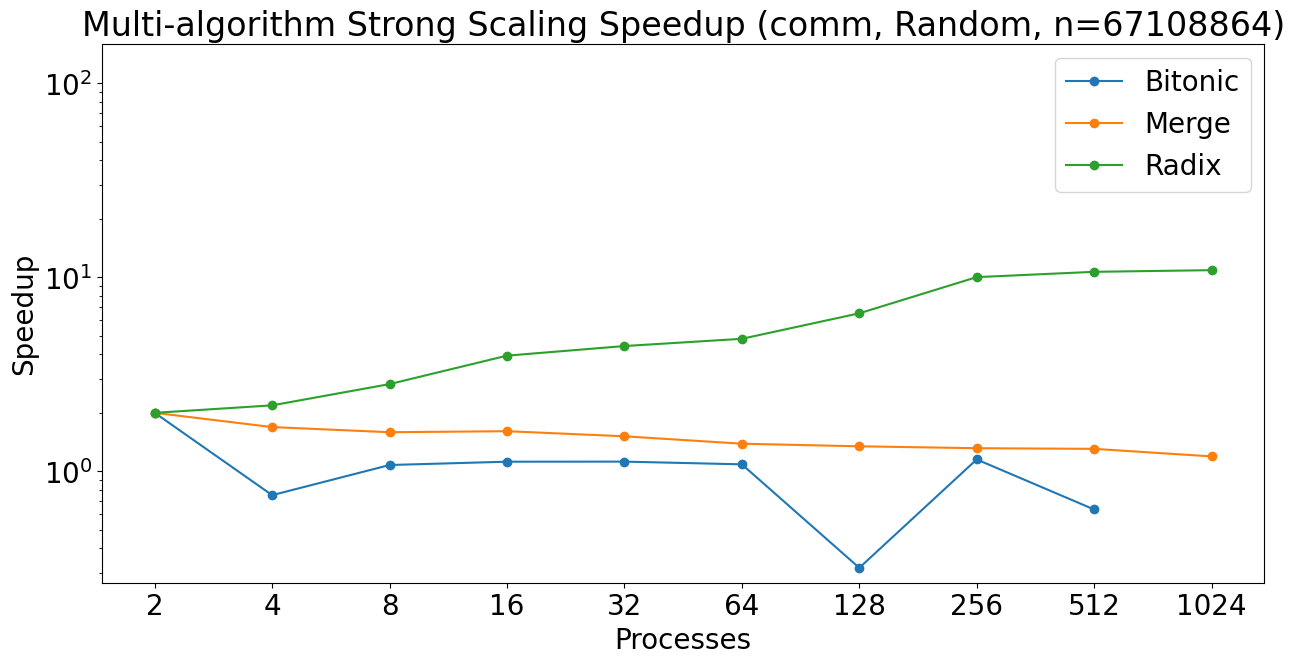

/tmp/ipykernel_11219/319951227.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ylim)


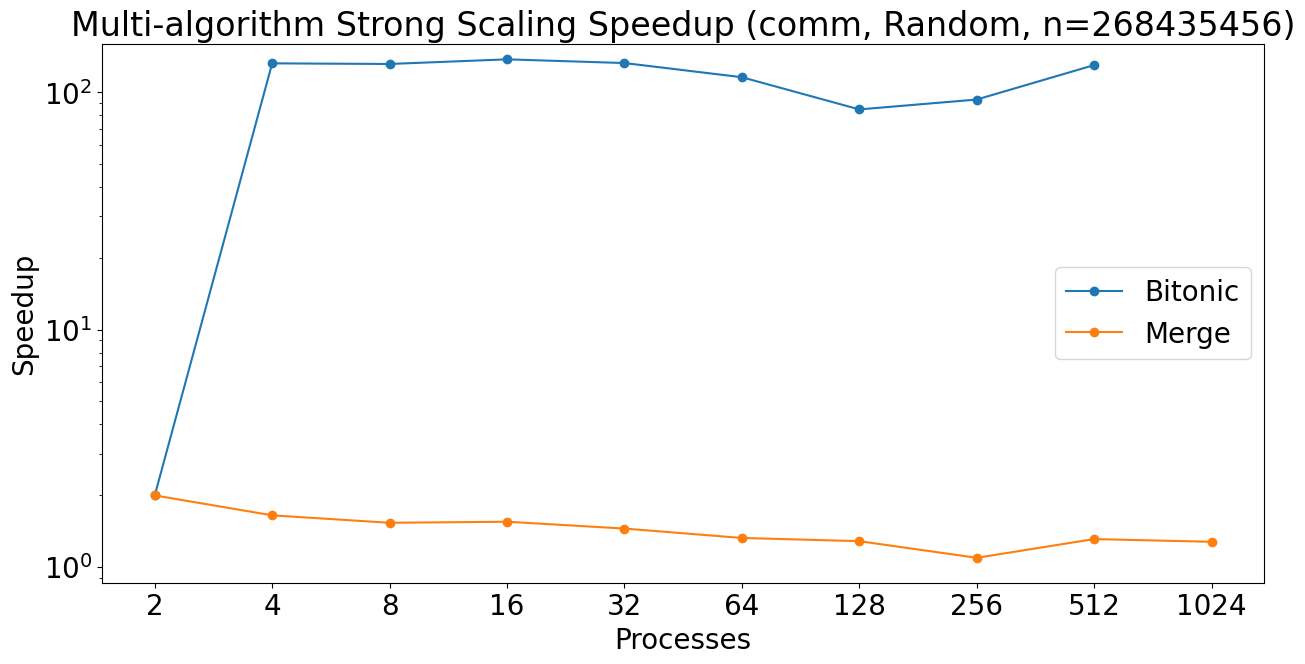

comp_large


/tmp/ipykernel_11219/319951227.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ylim)


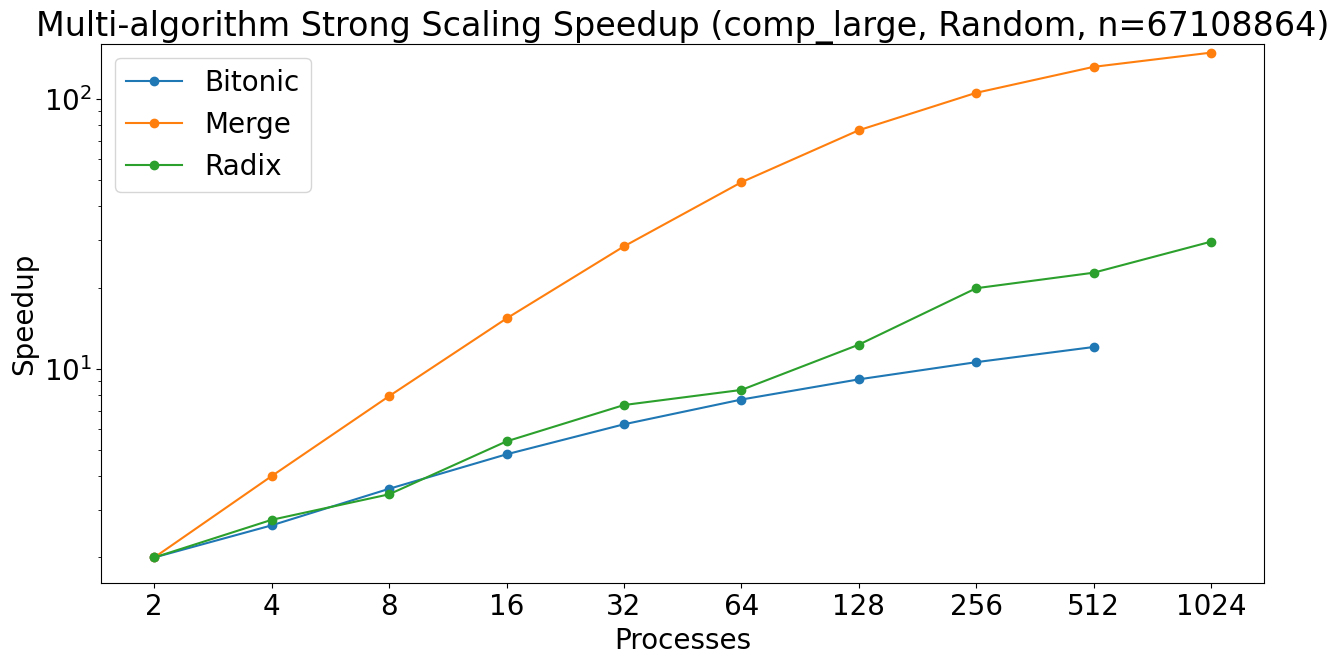

/tmp/ipykernel_11219/319951227.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ylim)


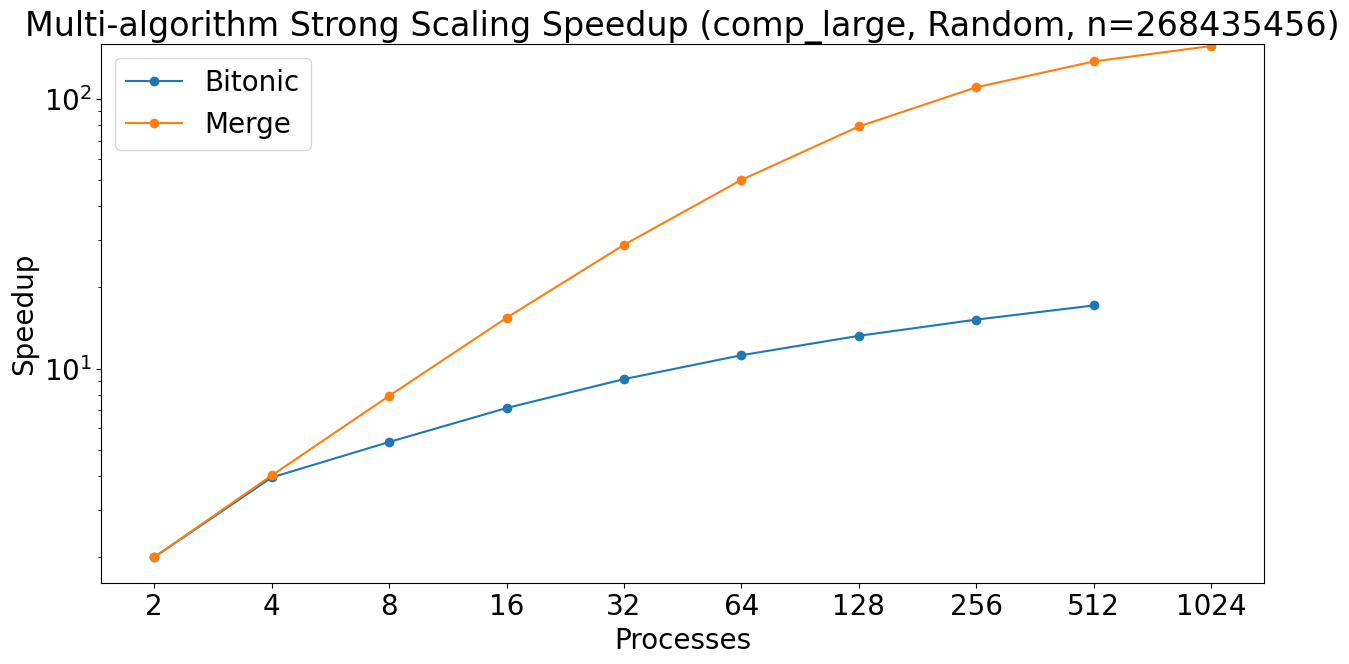

In [14]:
#iterate through nodes, and if comp_large, comm, or main, print the strong scaling
title_template0 = "Multi-algorithm Strong Scaling Speedup ({}, {}, n={})"#, scaled for synchronized y limits)"

scales = {'main': 8, 'comm': 8, 'comp_large': 79}

for node in merge_tk['Random'].graph.traverse():
    if node.frame['name'] == 'main' or node.frame['name'] == 'comp_large' or node.frame['name'] == 'comm':
        # for input size n, plot 4 plots for each input_type
        print(node.frame['name'])

        itype = 'Random'
        
        #for itype in input_type:
        for n in [2**26, 2**28]:
            # title will be node.frame['name']_input_size
            title = title_template0.format(node.frame['name'], itype, n)

            fig = plt.figure(figsize=(15,7))
            ax = fig.add_subplot(1, 1, 1)

            for name, tk in [
                ('Bitonic', bitonic_tk),
                #('Sample', sample_tk), # TODO: Upload the remaining Sample Sort Caliper files
                ('Merge', merge_tk),
                ('Radix', radix_tk),
            ]:
                if (n == 2**28 and name == 'Radix'):
                    continue
                
                df = tk[itype].dataframe.loc[node, 'Avg time/rank'] # get average time
                #df = (df.loc[df.index.get_level_values('input_type') == itype])
                df = (df.loc[df.index.get_level_values('num_procs') >= 2])
                #df = (df.loc[df.index.get_level_values('num_procs') < 1024])

                df = (df.loc[df.index.get_level_values('input_size') == n])
            
                df = df.unstack(level="input_size")
                #df = df.unstack(level="input_type")
                twoProcTimes = (df.loc[df.index.get_level_values('num_procs') == 2].values)[0]

                for i in range(0,len(twoProcTimes)):
                    twoProc = twoProcTimes[i]
                    df[n] = (df[n] / (2*twoProc))**-1

                ax.plot(df, marker='o', label=name)

            show_mpl_plot(fig, ax, title, "Processes", "Speedup", None,
                          #ylim=(0, 15200), # Synchronized with other groupmates
                          ylim=(0, 160), # Synchronized only with merge sort strong scaling
                          #ylim=(2**-3, 2**14),
                          ylog=True,
                         )

### Weak Scaling plots for each input type
- Increasing the problem size and processors
- Following our original plan from report section 2c: n=2^20/p=4, n=2^22/p=16, n=2^24/p=64, n=2^26/p=256, n=2^28/p=1024.

In [15]:
#iterate through nodes, and if comp_large, comm, or main, print the strong scaling
title_template0 = "Merge Sort Weak Scaling ({})"#, scaled for synchronized y limits)"

np_pairs = [(2**20, 4), (2**22, 16), (2**24, 64), (2**26, 256), (2**28, 1024)]

# For use when 1024-processor runs are unavailable, for example because Grace broke.
# This can also be useful if an algorithm doesn't work with 2^28 array elements:
np_pairs_backup = [(2**18, 2), (2**20, 8), (2**22, 32), (2**24, 128), (2**26, 512)]
np_pairs_backup = [(x*4, y) for x, y in np_pairs_backup]
np_pairs = np_pairs_backup

x_labels = ['n={}\np={}'.format(n, p) for n, p in np_pairs]

data = {}
for itype in input_type:
    data[itype] = {region: [] for region in measurement_regions}

    for n, p in np_pairs:
        path = "Merge_Cali/n{}-p{}-{}.cali".format(n, p, itype)
        print(path)
        tk_tmp = th.Thicket.from_caliperreader(glob(path))
        tk_tmp.metadata_column_to_perfdata("num_procs")
        tk_tmp.metadata_column_to_perfdata("input_size")
        for node in tk_tmp.graph.traverse():
            if (node.frame['name'] not in measurement_regions):
                continue

            value = list(tk_tmp.dataframe.loc[node, 'Avg time/rank'])[0]
            #print(value)
            data[itype][node.frame['name']].append(value)

for region in measurement_regions:

    title = title_template0.format(region)

    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 1, 1)
    
    for t in input_type:
        ax.plot(range(len(data[t][region])), data[t][region], label=t, marker='o')
                          
    ax.set_title(title)
    ax.set_xlabel('Configuration')
    ax.set_ylabel('Time (s)')
    ax.legend()#legend)
    #plt.xscale("log", base=2)
    plt.xticks(range(len(np_pairs)))
    ax.set_xticklabels(x_labels)

    #plt.yscale("log", base=2)
    plt.ylim(bottom=0)
    #plt.ylim((0, 1600)) # Synchronized with groupmates
    #plt.ylim((0, 4.75)) # Synchronized only with merge weak scaling
    
    plt.savefig(f'Merge_Plots/{title}')
    plt.show()

Merge_Cali/n1048576-p2-Sorted.cali


0it [00:00, ?it/s]


IndexError: list index out of range